In [1]:
USER = "Zisimopoulou"
CLONE_URL = f"https://github.com/{USER}/SkimLit-NLP-Project.git"
get_ipython().system(f"git clone {CLONE_URL}")

import sys
sys.path.append("SkimLit-NLP-Project")

Cloning into 'SkimLit-NLP-Project'...
remote: Enumerating objects: 186, done.
remote: Counting objects: 100% (186/186), done.
remote: Compressing objects: 100% (139/139), done.
remote: Total 186 (delta 51), reused 0 (delta 0), pack-reused 0
Receiving objects: 100% (186/186), 43.71 KiB | 1.62 MiB/s, done.
Resolving deltas: 100% (51/51), done.


In [2]:
import tensorflow as tf
import pandas as pd
import os
import numpy as np
import random
import string
import tensorflow_hub as hub
from tensorflow.keras.utils import plot_model
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt
from tensorflow.keras import layers
from tensorflow.keras.layers import TextVectorization

!git clone https://github.com/Franck-Dernoncourt/pubmed-rct.git
from data.data_loader import load_and_preprocess_pubmed_data, perform_one_hot_encoding, perform_label_encoding, create_tf_datasets, split_chars_in_sentences, create_char_vectorizer, create_char_token_datasets, create_position_char_token_datasets, one_hot_encode_categorical
from utils.helper_functions import calculate_results, train_and_evaluate_model, create_char_embedding_layer, train_and_evaluate_model_with_callbacks
from models.models import create_and_compile_ga_model, create_and_compile_pretrained_embedding_model, build_conv1D_char_embedding_model, build_token_char_hybrid_model, build_position_char_token_embedding_model, build_modified_trihybrid_model

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


Cloning into 'pubmed-rct'...
remote: Enumerating objects: 39, done.
remote: Counting objects: 100% (14/14), done.
remote: Compressing objects: 100% (9/9), done.
remote: Total 39 (delta 8), reused 5 (delta 5), pack-reused 25
Receiving objects: 100% (39/39), 177.08 MiB | 51.65 MiB/s, done.
Resolving deltas: 100% (15/15), done.


In [3]:
one_hot_encoder = OneHotEncoder(sparse_output=False)
label_encoder = LabelEncoder()

train_df, val_df, test_df, train_sentences, val_sentences, test_sentences = load_and_preprocess_pubmed_data(os.getcwd())

train_labels_one_hot, val_labels_one_hot, test_labels_one_hot = perform_one_hot_encoding(
    one_hot_encoder, train_df, val_df, test_df, target_column="target"
)

train_labels_encoded, val_labels_encoded, test_labels_encoded = perform_label_encoding(
    label_encoder, train_df, val_df, test_df, target_column="target"
)

train_dataset = create_tf_datasets(train_sentences, train_labels_one_hot)
valid_dataset = create_tf_datasets(val_sentences, val_labels_one_hot)
test_dataset = create_tf_datasets(test_sentences, test_labels_one_hot)

In [4]:
max_tokens = 68000
num_classes = len(label_encoder.classes_)
class_names = label_encoder.classes_
tf_hub_embedding_layer = hub.KerasLayer("https://tfhub.dev/google/universal-sentence-encoder/4",
                                        trainable=False,
                                        name="universal_sentence_encoder")

In [5]:
# Model 1:

# Text classification model with custom token embeddings and Conv1D layers.
ga_model = create_and_compile_ga_model(max_tokens, num_classes, train_sentences)
ga_model_preds, ga_model_history = train_and_evaluate_model(
    ga_model, train_dataset, valid_dataset, num_epochs=3
)

ga_model_results = calculate_results(val_labels_encoded, ga_model_preds)
print("Global Average Model Results:\n", ga_model_results)

Epoch 1/3
562/562 [==============================] - 47s 58ms/step - loss: 0.9309 - accuracy: 0.6330 - val_loss: 0.6861 - val_accuracy: 0.7384
Epoch 2/3
562/562 [==============================] - 7s 13ms/step - loss: 0.6587 - accuracy: 0.7562 - val_loss: 0.6295 - val_accuracy: 0.7693
Epoch 3/3
945/945 [==============================] - 2s 2ms/step
Global Average Model Results:
 {'accuracy': 78.72037600953263, 'precision': 0.7835385339263933, 'recall': 0.7872037600953263, 'f1': 0.7847939405250688}


In [6]:
# Model 2:

# Creates and compiles a model with a pre-trained embedding layer for text classification
pretrained_embedding_model = create_and_compile_pretrained_embedding_model(tf_hub_embedding_layer, num_classes)
pretrained_embedding_model_preds, pretrained_embedding_model_history = train_and_evaluate_model(
    pretrained_embedding_model, train_dataset, valid_dataset, num_epochs=3
)

pretrained_embedding_results = calculate_results(val_labels_encoded, pretrained_embedding_model_preds)
print("Pre-trained Embedding Model Results:\n", pretrained_embedding_results)

Epoch 1/3
562/562 [==============================] - 12s 13ms/step - loss: 0.9162 - accuracy: 0.6489 - val_loss: 0.8011 - val_accuracy: 0.6885
Epoch 2/3
562/562 [==============================] - 6s 11ms/step - loss: 0.7708 - accuracy: 0.7016 - val_loss: 0.7583 - val_accuracy: 0.7045
Epoch 3/3
945/945 [==============================] - 9s 9ms/step
Pre-trained Embedding Model Results:
 {'accuracy': 71.30941347808817, 'precision': 0.7138099659713074, 'recall': 0.7130941347808818, 'f1': 0.710051684310957}


In [7]:
train_chars = split_chars_in_sentences(train_sentences)
val_chars = split_chars_in_sentences(val_sentences)
test_chars = split_chars_in_sentences(test_sentences)

char_vectorizer = create_char_vectorizer(train_sentences, train_chars)
char_embedding_layer = create_char_embedding_layer(char_vectorizer, train_chars)

train_char_dataset = tf.data.Dataset.from_tensor_slices((train_chars, train_labels_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)
val_char_dataset = tf.data.Dataset.from_tensor_slices((val_chars, val_labels_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)

In [8]:
# Model 3:

# Builds a Conv1D character embedding model for text classification.
conv1D_char_embedding_model = build_conv1D_char_embedding_model(char_vectorizer, char_embedding_layer, num_classes)
conv1D_char_embedding_model_preds, conv1D_char_embedding_model_history = train_and_evaluate_model(
    conv1D_char_embedding_model, train_char_dataset, val_char_dataset, num_epochs=3
)
conv1D_char_embedding_model_results = calculate_results(val_labels_encoded, conv1D_char_embedding_model_preds)
print("Conv1D Character Embedding Model Results:\n", conv1D_char_embedding_model_results)

Epoch 1/3
562/562 [==============================] - 4s 5ms/step - loss: 1.4201 - accuracy: 0.3961 - val_loss: 1.3547 - val_accuracy: 0.4176
Epoch 2/3
562/562 [==============================] - 3s 5ms/step - loss: 1.3421 - accuracy: 0.4295 - val_loss: 1.3357 - val_accuracy: 0.4375
Epoch 3/3
945/945 [==============================] - 3s 3ms/step
Conv1D Character Embedding Model Results:
 {'accuracy': 45.23699192373891, 'precision': 0.4427418690875206, 'recall': 0.4523699192373891, 'f1': 0.41243228295712014}


In [9]:
# 1. Setup token inputs/model
token_inputs = layers.Input(shape=[], dtype=tf.string, name="token_input")
token_embeddings = tf_hub_embedding_layer(token_inputs)
token_output = layers.Dense(128, activation="relu")(token_embeddings)
token_model = tf.keras.Model(inputs=token_inputs,
                             outputs=token_output)


In [10]:
# Model 4:

# Build and compile a hybrid model with token and character embeddings and additional layers for classification
token_char_hybrid_model = build_token_char_hybrid_model(token_model, char_vectorizer, char_embedding_layer, num_classes)
train_char_token_dataset = create_char_token_datasets(train_sentences, train_chars, train_labels_one_hot)
val_char_token_dataset = create_char_token_datasets(val_sentences, val_chars, val_labels_one_hot)

token_char_hybrid_model_preds, token_char_hybrid_model_history = train_and_evaluate_model(
    token_char_hybrid_model, train_char_token_dataset, val_char_token_dataset, num_epochs=3
)

token_char_hybrid_model_results = calculate_results(val_labels_encoded, token_char_hybrid_model_preds)
print("Token Character Model Results:\n", token_char_hybrid_model_results)

Epoch 1/3
562/562 [==============================] - 24s 32ms/step - loss: 0.9756 - accuracy: 0.6100 - val_loss: 0.8049 - val_accuracy: 0.6878
Epoch 2/3
562/562 [==============================] - 16s 29ms/step - loss: 0.8155 - accuracy: 0.6829 - val_loss: 0.7448 - val_accuracy: 0.7174
Epoch 3/3
945/945 [==============================] - 15s 15ms/step
Token Character Model Results:
 {'accuracy': 72.69958956705945, 'precision': 0.7308048231594336, 'recall': 0.7269958956705944, 'f1': 0.7247390214639784}


In [11]:
# One-hot encodes the categorical columns "total_lines" and "line_number" in the training, validation, and test datasets with specified depths for each category.
train_total_lines_one_hot = one_hot_encode_categorical(train_df, "total_lines", 20)
val_total_lines_one_hot = one_hot_encode_categorical(val_df, "total_lines", 20) 
train_line_numbers_one_hot = one_hot_encode_categorical(train_df, "line_number", 15)
val_line_numbers_one_hot = one_hot_encode_categorical(val_df, "line_number", 15)

# Creates a TensorFlow dataset by combining one-hot encoded line numbers, total lines, sentences, and characters
train_position_char_token_dataset = create_position_char_token_datasets(train_line_numbers_one_hot, train_total_lines_one_hot, train_sentences, train_chars, train_labels_one_hot)
val_position_char_token_dataset = create_position_char_token_datasets(val_line_numbers_one_hot, val_total_lines_one_hot, val_sentences, val_chars, val_labels_one_hot)


In [12]:
# MODEL 5:

# Compiles, trains, evaluates, and prints results for a positional token character embedding model using a specified number of epochs, leveraging pre-defined datasets and models.

position_char_token_embedding_model = build_position_char_token_embedding_model(char_vectorizer, char_embedding_layer, token_model)

position_char_token_embedding_model_preds, position_char_token_embedding_model_history = train_and_evaluate_model(
    position_char_token_embedding_model, train_position_char_token_dataset, val_position_char_token_dataset, num_epochs=3
)

position_char_token_embedding_model_results = calculate_results(
    val_labels_encoded, position_char_token_embedding_model_preds
)
print("Positional Token Character Model Results:\n", position_char_token_embedding_model_results)

Epoch 1/3
562/562 [==============================] - 24s 31ms/step - loss: 1.0468 - accuracy: 0.7604 - val_loss: 0.9749 - val_accuracy: 0.8065
Epoch 2/3
562/562 [==============================] - 17s 30ms/step - loss: 0.9571 - accuracy: 0.8235 - val_loss: 0.9505 - val_accuracy: 0.8201
Epoch 3/3
945/945 [==============================] - 16s 16ms/step
Positional Token Character Model Results:
 {'accuracy': 83.08619091751622, 'precision': 0.8305585878922727, 'recall': 0.8308619091751622, 'f1': 0.8302767876957093}


In [13]:
# MODEL 6:

# Compiles, trains, evaluates, and prints results for a positional token character embedding model, 
# while training it with specified callbacks for model checkpointing, early stopping, and learning rate reduction.

modified_trihybrid_model = build_modified_trihybrid_model(tf_hub_embedding_layer, token_model, num_classes)

modified_trihybrid_model_preds, modified_trihybrid_model_history = train_and_evaluate_model_with_callbacks(
    modified_trihybrid_model, train_position_char_token_dataset, val_position_char_token_dataset
)

modified_trihybrid_model_results = calculate_results(
    val_labels_encoded, modified_trihybrid_model_preds
)
print("Positional Token Character with Callbacks Model Results:\n", modified_trihybrid_model_results)

Epoch 1/50
5627/5627 [==============================] - 147s 25ms/step - loss: 0.9412 - accuracy: 0.8312 - val_loss: 0.9095 - val_accuracy: 0.8463 - lr: 0.0010
Epoch 2/50
5627/5627 [==============================] - 140s 25ms/step - loss: 0.9082 - accuracy: 0.8534 - val_loss: 0.9027 - val_accuracy: 0.8514 - lr: 0.0010
Epoch 3/50
5627/5627 [==============================] - 141s 25ms/step - loss: 0.8969 - accuracy: 0.8623 - val_loss: 0.9003 - val_accuracy: 0.8516 - lr: 0.0010
Epoch 4/50
5627/5627 [==============================] - 137s 24ms/step - loss: 0.8898 - accuracy: 0.8682 - val_loss: 0.9010 - val_accuracy: 0.8518 - lr: 0.0010
Epoch 4: early stopping
945/945 [==============================] - 18s 17ms/step
Positional Token Character with Callbacks Model Results:
 {'accuracy': 85.17807493711108, 'precision': 0.8518967949864378, 'recall': 0.8517807493711108, 'f1': 0.8491523925198678}


In [14]:
# Combine model results into a DataFrame
all_model_results = pd.DataFrame({"baseline": ga_model_results,
                                  "pretrained_embedding_model": pretrained_embedding_results,
                                  "custom_char_embed_conv1d": conv1D_char_embedding_model_results,
                                  "hybrid_char_token_embed": token_char_hybrid_model_results,
                                  "tribrid_pos_char_token_embed": position_char_token_embedding_model_results,
                                  "modified_trihybrid_model_with_callbacks": modified_trihybrid_model_results})
all_model_results = all_model_results.transpose()
all_model_results


,accuracy,precision,recall,f1
baseline,78.720376,0.783539,0.787204,0.784794
pretrained_embedding_model,71.309413,0.713810,0.713094,0.710052
custom_char_embed_conv1d,45.236992,0.442742,0.452370,0.412432
hybrid_char_token_embed,72.699590,0.730805,0.726996,0.724739
tribrid_pos_char_token_embed,83.086191,0.830559,0.830862,0.830277
modified_trihybrid_model_with_callbacks,85.178075,0.851897,0.851781,0.849152


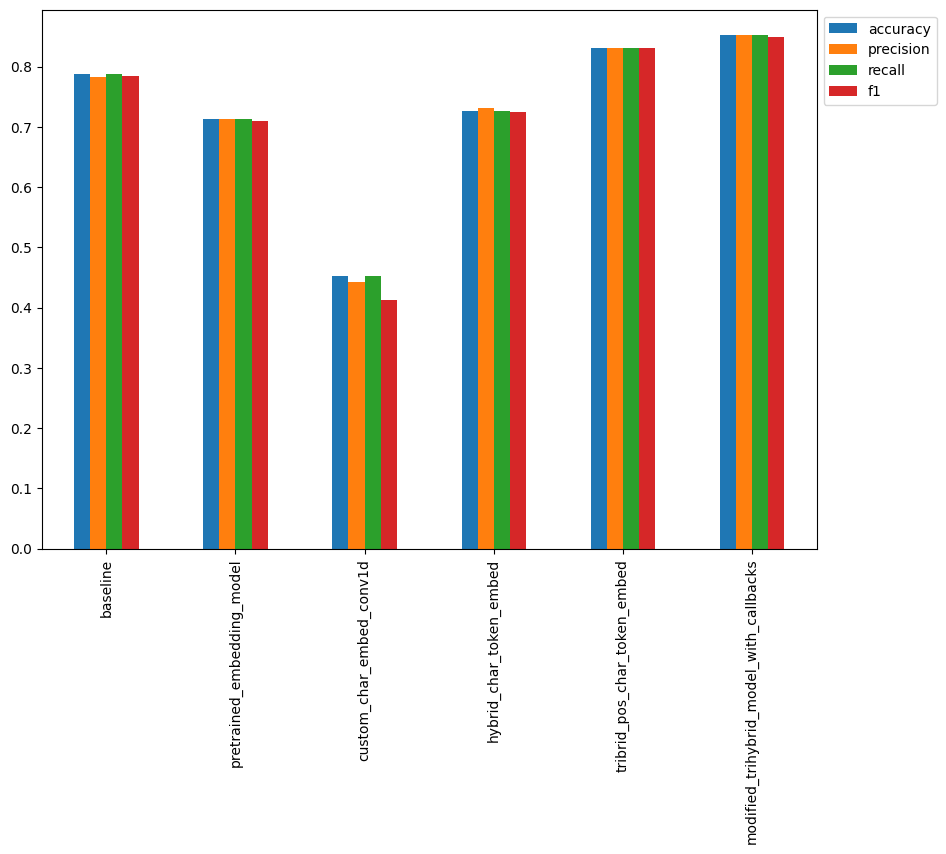

In [15]:
all_model_results["accuracy"] = all_model_results["accuracy"]/100
all_model_results.plot(kind="bar", figsize=(10, 7)).legend(bbox_to_anchor=(1.0, 1.0));


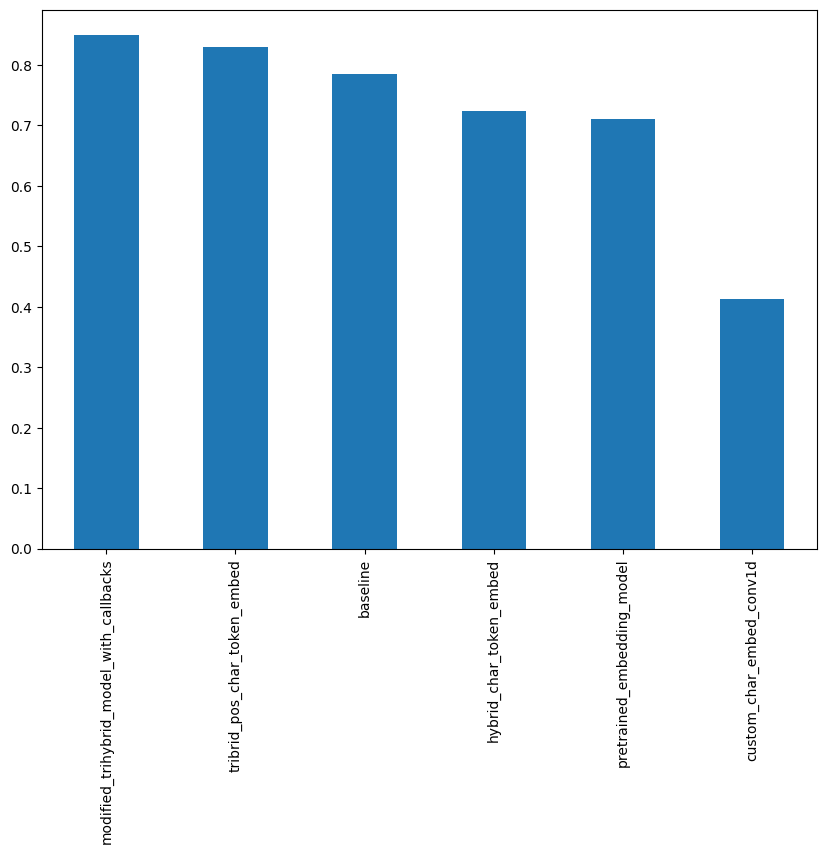

In [16]:
all_model_results.sort_values("f1", ascending=False)["f1"].plot(kind="bar", figsize=(10, 7));

In [18]:
# Choose the best model for our test data

test_total_lines_one_hot = one_hot_encode_categorical(test_df, "total_lines", 20) 
test_line_numbers_one_hot = one_hot_encode_categorical(test_df, "line_number", 15)
test_position_char_token_dataset = create_position_char_token_datasets(test_line_numbers_one_hot, test_total_lines_one_hot, test_sentences, test_chars, test_labels_one_hot)

test_pred_probs = modified_trihybrid_model.predict(test_position_char_token_dataset,
                                       verbose=1)
test_preds = tf.argmax(test_pred_probs, axis=1)

modified_trihybrid_model_test_results = calculate_results(y_true=test_labels_encoded,
                                              y_pred=test_preds)

test_pred_classes = [label_encoder.classes_[pred] for pred in test_preds]
test_df["prediction"] = test_pred_classes # create column with test prediction class names
test_df["pred_prob"] = tf.reduce_max(test_pred_probs, axis=1).numpy() # get the maximum prediction probability
test_df["correct"] = test_df["prediction"] == test_df["target"] # create binary column for whether the prediction is right or not
test_df.head(20)


top_100_wrong = test_df[test_df["correct"] == False].sort_values("pred_prob", ascending=False)[:100]
top_100_wrong

942/942 [==============================] - 17s 18ms/step


,target,text,line_number,total_lines,prediction,pred_prob,correct
22736,OBJECTIVE,"the national institute of oncology , budapest ...",4,20,METHODS,0.965263,False
8545,METHODS,pretest-posttest .,1,11,BACKGROUND,0.943035,False
16580,OBJECTIVE,"second , we collected patient-reported outcome...",4,27,METHODS,0.942583,False
20004,CONCLUSIONS,no treatment-related serious ae occurred .,10,11,RESULTS,0.923091,False
6365,CONCLUSIONS,adverse events up to the third postoperative d...,7,8,RESULTS,0.921991,False
...,...,...,...,...,...,...,...
10623,METHODS,at one month there was significant improvement...,6,12,RESULTS,0.856640,False
21180,OBJECTIVE,in patients undergoing bilateral tibial length...,2,17,METHODS,0.856584,False
18871,CONCLUSIONS,both hypotheses were rejected and apparently n...,6,9,RESULTS,0.856524,False
8638,METHODS,this study is registered with clinicaltrials.g...,5,9,RESULTS,0.856492,False


In [19]:
modified_trihybrid_model_test_results

{'accuracy': 84.61921353907417,
 'precision': 0.8455707697254213,
 'recall': 0.8461921353907417,
 'f1': 0.843517209289966}